In [1]:
%env CUDA_VISIBLE_DEVICES=0

import torch
import math

from bitsandbytes.functional import (
    quantize_fp4, quantize_nf4, quantize_blockwise,
    dequantize_fp4, dequantize_nf4, dequantize_blockwise,
)

from gptq.edenn import higgs_quantize_dequantize

from tqdm.auto import trange, tqdm

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype="auto", device_map="cpu")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
weight = model.model.layers[15].self_attn.q_proj.weight.data.cuda().clone().detach()

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 1.0464905066018135)

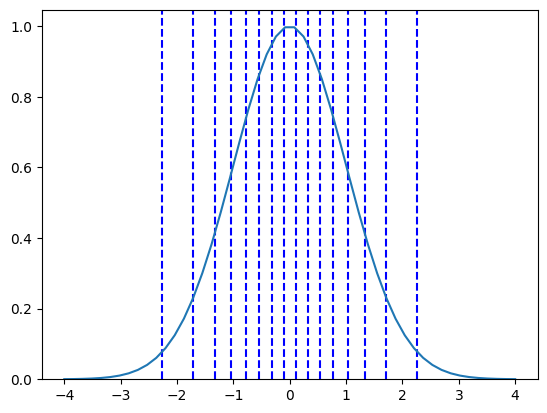

In [4]:
from scipy.stats import norm
import numpy as np

af_4_centers = np.linspace(-1, 1, num=16, endpoint=True)


for i in trange(1000):
    af_4_boundaries_quantiles = [0.0] + [norm.cdf((af_4_centers[i] + af_4_centers[i + 1]) / 2) for i in range(len(af_4_centers) - 1)] + [1.0]
    af_4_centers = [norm.ppf((af_4_boundaries_quantiles[i] + af_4_boundaries_quantiles[i + 1]) / 2) for i in range(len(af_4_boundaries_quantiles) - 1)]
    
    
import matplotlib.pyplot as plt
import numpy as np

for c in af_4_centers:
    plt.axvline(c, color="blue", linestyle="--")
    
plt.plot(np.linspace(-4, 4), np.exp(-np.linspace(-4, 4)**2/2))

plt.ylim(0, None)

In [5]:
AF4_GRID = torch.asarray(af_4_centers)[:, None].float().cuda()

In [6]:
def entropy(idx):
    _, counts = torch.unique(idx, return_counts=True)
    counts = counts.to(torch.float)
    return -torch.sum(counts / idx.numel() * torch.log2(counts / idx.numel())).item()

@torch.no_grad()
def higgs_grouped_quantize_dequantize(weight, d, n, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    scales = torch.norm(weight, dim=-1)[..., None] / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    for i in range(0, weight.shape[0], 1024):
        q, codes_entropy = higgs_quantize_dequantize(weight[i:i+1024].reshape(-1, d), d, n)
        weight[i:i+1024] = q.reshape(weight[i:i+1024].shape)
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1), codes_entropy / d


def create_nf4_grid(offset=0.9677083, symmetric=True):
    from scipy.stats import norm
    
    if symmetric:
        v = norm.ppf(torch.linspace(1/17, 1, 16)[:-1]).tolist()
    else:
        # one more positive value, this is an asymmetric type
        v1 = norm.ppf(torch.linspace(offset, 0.5, 9)[:-1]).tolist()
        v3 = (-norm.ppf(torch.linspace(offset, 0.5, 8)[:-1])).tolist()
        v = v1 + [0] + v3

    values = torch.Tensor(v)
    values = values.sort().values

    return values[:,None]

NF4_GRID = create_nf4_grid(symmetric=False).cuda()

@torch.no_grad()
def custom_grouped_quantize_dequantize(weight, grid, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    
    scales = torch.norm(weight, dim=-1)[..., None]
    
    scales = scales / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    ids = torch.argmax(2 * weight[..., None] @ grid.T - torch.linalg.norm(grid, dim=1) ** 2, -1)
    codes_entropy = entropy(ids)
    weight = grid[ids]
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1), codes_entropy

In [7]:
def bnb_nf4(w):
    codes, state = quantize_nf4(w)
    return dequantize_nf4(codes, state), entropy(torch.cat((codes // 16, codes % 16)))

def bnb_int8(w):
    codes, state = quantize_blockwise(w)
    return dequantize_blockwise(codes, state), entropy(codes)

In [8]:
grids = [
    {"name": "nf4", "qdq": lambda w: custom_grouped_quantize_dequantize(w, NF4_GRID)},
    {"name": "af4", "qdq": lambda w: custom_grouped_quantize_dequantize(w, AF4_GRID)},
    {"name": "EDEN", "qdq": lambda w: higgs_grouped_quantize_dequantize(w, 1, 2**4)},
    {"name": "HIGGS", "qdq": lambda w: higgs_grouped_quantize_dequantize(w, 2, 2**8)},
    {"name": "BnB nf4", "qdq": lambda w: bnb_nf4(w)},
    {"name": "BnB int8", "qdq": lambda w: bnb_int8(w)},
]

In [9]:
print("No Hadamard")

for grid in grids:
    qdq_weight, codes_entropy = grid["qdq"](weight)
    grid["rmse"] = (qdq_weight - weight).pow(2).sum() / weight.pow(2).sum()
    grid["l1_err"] = (qdq_weight - weight).abs().sum() / weight.abs().sum()
    grid["entropy"] = codes_entropy
    print(f"{grid['name']:<16}:    l2: {grid['rmse']:<8.4f} l1: {grid['l1_err']:<8.4f} ent: {codes_entropy:<8.2f}")

No Hadamard
nf4             :    l2: 0.0274   l1: 0.1060   ent: 4.00    
af4             :    l2: 0.0142   l1: 0.0950   ent: 3.91    
EDEN            :    l2: 0.0109   l1: 0.0996   ent: 3.76    
HIGGS           :    l2: 0.0086   l1: 0.0890   ent: 3.87    
BnB nf4         :    l2: 0.0086   l1: 0.0928   ent: 3.87    
BnB int8        :    l2: 0.0002   l1: 0.0131   ent: 7.05    


In [10]:
import math

from fast_hadamard_transform import hadamard_transform

h_weight = hadamard_transform(weight, scale=1/math.sqrt(weight.shape[-1]))

print("With Hadamard")

for grid in grids:
    qdq_h_weight, codes_entropy = grid["qdq"](h_weight)
    grid["h_rmse"] = (qdq_h_weight - h_weight).pow(2).sum().sqrt() / h_weight.pow(2).sum().sqrt()
    grid["h_l1_err"] = (qdq_h_weight - h_weight).abs().sum() / h_weight.abs().sum()
    grid["h_entropy"] = codes_entropy
    print(f"{grid['name']:<16}:    l2: {grid['h_rmse']:<8.4f} l1: {grid['h_l1_err']:<8.4f} ent: {codes_entropy:<8.2f}")

With Hadamard
nf4             :    l2: 0.1538   l1: 0.1040   ent: 4.00    
af4             :    l2: 0.1083   l1: 0.0935   ent: 3.91    
EDEN            :    l2: 0.0973   l1: 0.0985   ent: 3.77    
HIGGS           :    l2: 0.0879   l1: 0.0882   ent: 3.88    
BnB nf4         :    l2: 0.0918   l1: 0.0913   ent: 3.88    
BnB int8        :    l2: 0.0131   l1: 0.0125   ent: 7.07    


In [11]:
@torch.no_grad()
def llama_eval(model, dataloader, dev):
    print('Evaluating ...')

    nsamples = len(dataloader) 

    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.layers

    model.model.embed_tokens = model.model.embed_tokens.to(dev)
    model.model.rotary_emb = model.model.rotary_emb.to(dev)
    layers[0] = layers[0].to(dev)

    dtype = next(iter(model.parameters())).dtype
    inps = []
    attention_masks = []
    position_ids = []

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps.append(inp)
            attention_masks.append(kwargs['attention_mask'])
            position_ids.append(kwargs['position_ids'])
            raise ValueError
    layers[0] = Catcher(layers[0])
    for batch in dataloader:
        try:
            model(batch.to(dev))
        except ValueError:
            pass
    layers[0] = layers[0].module

    layers[0] = layers[0].cpu()
    model.model.embed_tokens = model.model.embed_tokens.cpu()
    torch.cuda.empty_cache()

    for i in trange(len(layers), desc=f"Evaluating layer-by-layer..."):
        layer = layers[i].to(dev)
        for j in range(nsamples):
            inps[j] = layer(inps[j], attention_mask=attention_masks[j], position_ids=position_ids[j])[0]
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()

    if model.model.norm is not None:
        model.model.norm = model.model.norm.to(dev)
    model.lm_head = model.lm_head.to(dev)

    nlls = []
    for i in range(nsamples):
        hidden_states = inps[i]
        if model.model.norm is not None:
            hidden_states = model.model.norm(hidden_states)
        lm_logits = model.lm_head(hidden_states)
        shift_logits = lm_logits[:, :-1, :].contiguous()
        shift_labels = (dataloader[i].to(dev))[:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * model.seqlen
        nlls.append(neg_log_likelihood)
    ppl = torch.exp(torch.stack(nlls).sum() / (nsamples * model.seqlen))
    print(ppl.item())

    model.config.use_cache = use_cache
    
    return ppl.item()

In [12]:
from torch import nn

from gptq.edenn import pad_to_block, HadLinear

def find_layers(module, layers=[nn.Linear], name=''):
    if type(module) in layers:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, layers=layers, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)
    
def replace_empty(model: nn.Module, had_block_size: int):
    linear_layers = find_layers(model)
    for name, layer in tqdm(linear_layers.items(), desc="Replacing linear layers..."):
        if "lm_head" in name:
            continue
        
        replace_submodule(model, name, HadLinear(pad_to_block(layer.weight, [1], had_block_size)))
    

@torch.no_grad()
def llama_rtn(model, hadamard_groupsize, device, qdq):
    linear_layers = find_layers(model)
    
    for (name, layer) in tqdm(linear_layers.items(), desc="Quantizing linear layers..."):
        if "lm_head" in name:
            continue
        
        weight = layer.weight.data.to(device)
        if hadamard_groupsize != 0:
            weight = pad_to_block(weight, [-1], hadamard_groupsize).reshape(weight.shape[0], -1, hadamard_groupsize)
            weight = hadamard_transform(weight).reshape(weight.shape[0], -1)
            
        quantized_weight, _ = qdq(weight)
        quantized_weight = quantized_weight.half()
        
        if hadamard_groupsize == 0:
            layer.weight.data = quantized_weight
            layer.cpu()
        else:
            replace_submodule(model, name, HadLinear(quantized_weight, hadamard_groupsize).cpu())
        
    return model

In [13]:
from gptq.datautils import *

for grid in []:
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype=torch.float16, device_map="cpu")
    model.seqlen = 8192
    model = llama_rtn(model, 1024, "cuda", grid["qdq"])
    
    datasets = ['wikitext2'] 
    for dataset in datasets:
        dataloader, testloader = get_loaders(
            dataset, seed=0, model="meta-llama/Meta-Llama-3.1-8B", seqlen=8192
        )
        ppl = llama_eval(model, testloader, "cuda")
        grid[f"h_ppl_{dataset}"] = ppl

In [14]:
print("With Hadamard")

for grid in grids:
    print(f"{grid['name']:<16}:    l2: {grid['h_rmse']:<8.4f} l1: {grid['h_l1_err']:<8.4f} entropy: {grid['h_entropy']:<8.2f} ppl : {grid['h_ppl_wikitext2'] if 'h_ppl_wikitext2' in grid else 0.0:<8.2f}")

With Hadamard
nf4             :    l2: 0.1538   l1: 0.1040   entropy: 4.00     ppl : 0.00    
af4             :    l2: 0.1083   l1: 0.0935   entropy: 3.91     ppl : 0.00    
EDEN            :    l2: 0.0973   l1: 0.0985   entropy: 3.77     ppl : 0.00    
HIGGS           :    l2: 0.0879   l1: 0.0882   entropy: 3.88     ppl : 0.00    
BnB nf4         :    l2: 0.0918   l1: 0.0913   entropy: 3.88     ppl : 0.00    
BnB int8        :    l2: 0.0131   l1: 0.0125   entropy: 7.07     ppl : 0.00    


In [15]:
from gptq.datautils import *

for grid in []:
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype=torch.float16, device_map="cpu")
    model.seqlen = 8192
    model = llama_rtn(model, 0, "cuda", grid["qdq"])
    
    datasets = ['wikitext2'] 
    for dataset in datasets:
        dataloader, testloader = get_loaders(
            dataset, seed=0, model="meta-llama/Meta-Llama-3.1-8B", seqlen=8192
        )
        ppl = llama_eval(model, testloader, "cuda")
        grid[f"ppl_{dataset}"] = ppl

In [16]:
print("No Hadamard")

for grid in grids:
    print(f"{grid['name']:<16}:    l2: {grid['rmse']:<8.4f} l1: {grid['l1_err']:<8.4f} entropy: {grid['entropy']:<8.2f} ppl : {grid['ppl_wikitext2'] if 'ppl_wikitext2' in grid else 0.0:<8.4f}")

No Hadamard
nf4             :    l2: 0.0274   l1: 0.1060   entropy: 4.00     ppl : 0.0000  
af4             :    l2: 0.0142   l1: 0.0950   entropy: 3.91     ppl : 0.0000  
EDEN            :    l2: 0.0109   l1: 0.0996   entropy: 3.76     ppl : 0.0000  
HIGGS           :    l2: 0.0086   l1: 0.0890   entropy: 3.87     ppl : 0.0000  
BnB nf4         :    l2: 0.0086   l1: 0.0928   entropy: 3.87     ppl : 0.0000  
BnB int8        :    l2: 0.0002   l1: 0.0131   entropy: 7.05     ppl : 0.0000  


In [17]:
def get_zero_shots(model, task_list = ('arc_easy',), num_fewshots=1):
    import lm_eval

    lm_eval_model = lm_eval.models.huggingface.HFLM(
        pretrained=model,
    )

    tasks = lm_eval.tasks.get_task_dict(task_list)
    if num_fewshots != 1:
        # TODO: make fewshots properly
        for task_name in tasks:
            task = tasks[task_name]
            if isinstance(task, tuple):
                task = task[1]
            if task is None:
                continue
            task.config.num_fewshot = num_fewshots

    results = lm_eval.evaluator.evaluate(
        lm=lm_eval_model,
        task_dict=tasks,
    )

    result_dict = {task_name: task_result['acc,none'] for task_name, task_result in results['results'].items()}
    result_err_dict = {f'{task_name}_err': task_result['acc_stderr,none'] for task_name, task_result in
                       results['results'].items()}
    result_dict = dict(list(result_dict.items()) + list(result_err_dict.items()))

    if num_fewshots != 1:
        result_dict = {f'{task_name}@{num_fewshots}': acc for task_name, acc in result_dict.items()}

    return result_dict

In [22]:
grids[:1]

[{'name': 'nf4',
  'qdq': <function __main__.<lambda>(w)>,
  'rmse': tensor(0.0274, device='cuda:0'),
  'l1_err': tensor(0.1060, device='cuda:0'),
  'entropy': 3.9961915016174316,
  'h_rmse': tensor(0.1538, device='cuda:0'),
  'h_l1_err': tensor(0.1040, device='cuda:0'),
  'h_entropy': 3.996105194091797}]

In [31]:
for grid in grids[-2:-1]:
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype=torch.float16, device_map="cpu")
    model.seqlen = 8192
    model = llama_rtn(model, 1024, "cuda", grid["qdq"]).cuda()
    # results = get_zero_shots(
    #     model,
    #     task_list=("mmlu",),
    #     num_fewshots=5,
    # )
    results = get_zero_shots(model, task_list = ('winogrande','piqa','arc_easy','arc_challenge'), num_fewshots=1)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantizing linear layers...:   0%|          | 0/225 [00:00<?, ?it/s]

2024-09-30:10:02:25,315 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-09-30:10:02:26,353 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-09-30:10:02:44,204 INFO     [task.py:386] Building contexts for arc_challenge on rank 0...
100%|██████████| 1172/1172 [00:00<00:00, 1514.22it/s]
2024-09-30:10:02:45,027 INFO     [task.py:386] Building contexts for arc_easy on rank 0...
100%|██████████| 2376/2376 [00:01<00:00, 1491.61it/s]
2024-09-30:10:02:46,716 INFO     [task.py:386] Building contexts for piqa on rank 0...
100%|██████████| 1838/1838 [00:01<00:00, 1432.68it/s]
2024-09-30:10:02:48,051 INFO     [task.py:386] Building contexts for winogrande on rank 0...
100%|██████████| 1267/1267 [00:00<00:

In [35]:
results

{'arc_challenge': 0.5179180887372014,
 'arc_easy': 0.8156565656565656,
 'piqa': 0.794885745375408,
 'winogrande': 0.7300710339384373,
 'arc_challenge_err': 0.014602005585490976,
 'arc_easy_err': 0.007956749734670018,
 'piqa_err': 0.009420971671017913,
 'winogrande_err': 0.0124764333720026}

bnb nf4
```json
{'mmlu@5': 0.6329582680529839,
 'mmlu_humanities@5': 0.5804463336875664,
 'mmlu_formal_logic@5': 0.40476190476190477,
 'mmlu_high_school_european_history@5': 0.7757575757575758,
 'mmlu_high_school_us_history@5': 0.7745098039215687,
 'mmlu_high_school_world_history@5': 0.8059071729957806,
 'mmlu_international_law@5': 0.7933884297520661,
 'mmlu_jurisprudence@5': 0.7314814814814815,
 'mmlu_logical_fallacies@5': 0.7423312883435583,
 'mmlu_moral_disputes@5': 0.708092485549133,
 'mmlu_moral_scenarios@5': 0.41787709497206704,
 'mmlu_philosophy@5': 0.729903536977492,
 'mmlu_prehistory@5': 0.7006172839506173,
 'mmlu_professional_law@5': 0.45436766623207303,
 'mmlu_world_religions@5': 0.8011695906432749,
 'mmlu_other@5': 0.7077566784679755,
 'mmlu_business_ethics@5': 0.64,
 'mmlu_clinical_knowledge@5': 0.7358490566037735,
 'mmlu_college_medicine@5': 0.6473988439306358,
 'mmlu_global_facts@5': 0.34,
 'mmlu_human_aging@5': 0.6591928251121076,
 'mmlu_management@5': 0.8058252427184466,
 'mmlu_marketing@5': 0.8376068376068376,
 'mmlu_medical_genetics@5': 0.82,
 'mmlu_miscellaneous@5': 0.822477650063857,
 'mmlu_nutrition@5': 0.7483660130718954,
 'mmlu_professional_accounting@5': 0.4787234042553192,
 'mmlu_professional_medicine@5': 0.6764705882352942,
 'mmlu_virology@5': 0.5662650602409639,
 'mmlu_social_sciences@5': 0.737081572960676,
 'mmlu_econometrics@5': 0.47368421052631576,
 'mmlu_high_school_geography@5': 0.8181818181818182,
 'mmlu_high_school_government_and_politics@5': 0.8549222797927462,
 'mmlu_high_school_macroeconomics@5': 0.6051282051282051,
 'mmlu_high_school_microeconomics@5': 0.6974789915966386,
 'mmlu_high_school_psychology@5': 0.8238532110091743,
 'mmlu_human_sexuality@5': 0.7786259541984732,
 'mmlu_professional_psychology@5': 0.6862745098039216,
 'mmlu_public_relations@5': 0.6818181818181818,
 'mmlu_security_studies@5': 0.7551020408163265,
 'mmlu_sociology@5': 0.8407960199004975,
 'mmlu_us_foreign_policy@5': 0.85,
 'mmlu_stem@5': 0.5359974627339043,
 'mmlu_abstract_algebra@5': 0.36,
 'mmlu_anatomy@5': 0.5851851851851851,
 'mmlu_astronomy@5': 0.6842105263157895,
 'mmlu_college_biology@5': 0.7291666666666666,
 'mmlu_college_chemistry@5': 0.4,
 'mmlu_college_computer_science@5': 0.48,
 'mmlu_college_mathematics@5': 0.39,
 'mmlu_college_physics@5': 0.46078431372549017,
 'mmlu_computer_security@5': 0.79,
 'mmlu_conceptual_physics@5': 0.5659574468085107,
 'mmlu_electrical_engineering@5': 0.6413793103448275,
 'mmlu_elementary_mathematics@5': 0.42328042328042326,
 'mmlu_high_school_biology@5': 0.7387096774193549,
 'mmlu_high_school_chemistry@5': 0.5123152709359606,
 'mmlu_high_school_computer_science@5': 0.68,
 'mmlu_high_school_mathematics@5': 0.3925925925925926,
 'mmlu_high_school_physics@5': 0.4105960264900662,
 'mmlu_high_school_statistics@5': 0.5185185185185185,
 'mmlu_machine_learning@5': 0.4107142857142857,
 'mmlu_err@5': 0.0038553633319567235,
 'mmlu_humanities_err@5': 0.006830725995949764,
 'mmlu_formal_logic_err@5': 0.04390259265377562,
 'mmlu_high_school_european_history_err@5': 0.032568666616811015,
 'mmlu_high_school_us_history_err@5': 0.029331162294251728,
 'mmlu_high_school_world_history_err@5': 0.025744902532290927,
 'mmlu_international_law_err@5': 0.03695980128098826,
 'mmlu_jurisprudence_err@5': 0.042844679680521934,
 'mmlu_logical_fallacies_err@5': 0.03436150827846917,
 'mmlu_moral_disputes_err@5': 0.024476994076247333,
 'mmlu_moral_scenarios_err@5': 0.016495400635820084,
 'mmlu_philosophy_err@5': 0.02521804037341062,
 'mmlu_prehistory_err@5': 0.02548311560119547,
 'mmlu_professional_law_err@5': 0.012716941720734804,
 'mmlu_world_religions_err@5': 0.03061111655743253,
 'mmlu_other_err@5': 0.007846856943447255,
 'mmlu_business_ethics_err@5': 0.04824181513244218,
 'mmlu_clinical_knowledge_err@5': 0.027134291628741716,
 'mmlu_college_medicine_err@5': 0.036430371689585475,
 'mmlu_global_facts_err@5': 0.04760952285695235,
 'mmlu_human_aging_err@5': 0.031811497470553604,
 'mmlu_management_err@5': 0.03916667762822585,
 'mmlu_marketing_err@5': 0.024161618127987745,
 'mmlu_medical_genetics_err@5': 0.03861229196653694,
 'mmlu_miscellaneous_err@5': 0.013664230995834838,
 'mmlu_nutrition_err@5': 0.024848018263875195,
 'mmlu_professional_accounting_err@5': 0.029800481645628693,
 'mmlu_professional_medicine_err@5': 0.02841820861940675,
 'mmlu_virology_err@5': 0.03858158940685517,
 'mmlu_social_sciences_err@5': 0.00775705595663684,
 'mmlu_econometrics_err@5': 0.04697085136647863,
 'mmlu_high_school_geography_err@5': 0.02747960301053878,
 'mmlu_high_school_government_and_politics_err@5': 0.025416343096306426,
 'mmlu_high_school_macroeconomics_err@5': 0.024784316942156395,
 'mmlu_high_school_microeconomics_err@5': 0.02983796238829193,
 'mmlu_high_school_psychology_err@5': 0.01633288239343138,
 'mmlu_human_sexuality_err@5': 0.03641297081313729,
 'mmlu_professional_psychology_err@5': 0.01877168389352818,
 'mmlu_public_relations_err@5': 0.04461272175910508,
 'mmlu_security_studies_err@5': 0.027529637440174903,
 'mmlu_sociology_err@5': 0.025870646766169136,
 'mmlu_us_foreign_policy_err@5': 0.035887028128263686,
 'mmlu_stem_err@5': 0.008591568898741093,
 'mmlu_abstract_algebra_err@5': 0.048241815132442176,
 'mmlu_anatomy_err@5': 0.04256193767901408,
 'mmlu_astronomy_err@5': 0.0378272898086547,
 'mmlu_college_biology_err@5': 0.037161774375660164,
 'mmlu_college_chemistry_err@5': 0.049236596391733084,
 'mmlu_college_computer_science_err@5': 0.050211673156867795,
 'mmlu_college_mathematics_err@5': 0.04902071300001975,
 'mmlu_college_physics_err@5': 0.04959859966384181,
 'mmlu_computer_security_err@5': 0.040936018074033256,
 'mmlu_conceptual_physics_err@5': 0.03240038086792747,
 'mmlu_electrical_engineering_err@5': 0.03996629574876719,
 'mmlu_elementary_mathematics_err@5': 0.025446365634406783,
 'mmlu_high_school_biology_err@5': 0.02499305339776483,
 'mmlu_high_school_chemistry_err@5': 0.035169204442208966,
 'mmlu_high_school_computer_science_err@5': 0.04688261722621504,
 'mmlu_high_school_mathematics_err@5': 0.029773847012532967,
 'mmlu_high_school_physics_err@5': 0.04016689594849929,
 'mmlu_high_school_statistics_err@5': 0.03407632093854051,
 'mmlu_machine_learning_err@5': 0.04669510663875191}
```

bnb int8
```json
{'mmlu@5': 0.6531120922945449,
 'mmlu_humanities@5': 0.5991498405951116,
 'mmlu_formal_logic@5': 0.48412698412698413,
 'mmlu_high_school_european_history@5': 0.7757575757575758,
 'mmlu_high_school_us_history@5': 0.8284313725490197,
 'mmlu_high_school_world_history@5': 0.8354430379746836,
 'mmlu_international_law@5': 0.8264462809917356,
 'mmlu_jurisprudence@5': 0.7407407407407407,
 'mmlu_logical_fallacies@5': 0.7423312883435583,
 'mmlu_moral_disputes@5': 0.7225433526011561,
 'mmlu_moral_scenarios@5': 0.4,
 'mmlu_philosophy@5': 0.7202572347266881,
 'mmlu_prehistory@5': 0.7160493827160493,
 'mmlu_professional_law@5': 0.49478487614080835,
 'mmlu_world_religions@5': 0.8128654970760234,
 'mmlu_other@5': 0.7199871258448665,
 'mmlu_business_ethics@5': 0.65,
 'mmlu_clinical_knowledge@5': 0.7660377358490567,
 'mmlu_college_medicine@5': 0.6358381502890174,
 'mmlu_global_facts@5': 0.31,
 'mmlu_human_aging@5': 0.695067264573991,
 'mmlu_management@5': 0.8252427184466019,
 'mmlu_marketing@5': 0.8589743589743589,
 'mmlu_medical_genetics@5': 0.82,
 'mmlu_miscellaneous@5': 0.80970625798212,
 'mmlu_nutrition@5': 0.7908496732026143,
 'mmlu_professional_accounting@5': 0.5035460992907801,
 'mmlu_professional_medicine@5': 0.7022058823529411,
 'mmlu_virology@5': 0.5783132530120482,
 'mmlu_social_sciences@5': 0.7621059473513162,
 'mmlu_econometrics@5': 0.4649122807017544,
 'mmlu_high_school_geography@5': 0.8181818181818182,
 'mmlu_high_school_government_and_politics@5': 0.8911917098445595,
 'mmlu_high_school_macroeconomics@5': 0.6461538461538462,
 'mmlu_high_school_microeconomics@5': 0.7394957983193278,
 'mmlu_high_school_psychology@5': 0.8532110091743119,
 'mmlu_human_sexuality@5': 0.7709923664122137,
 'mmlu_professional_psychology@5': 0.7156862745098039,
 'mmlu_public_relations@5': 0.7181818181818181,
 'mmlu_security_studies@5': 0.7428571428571429,
 'mmlu_sociology@5': 0.8805970149253731,
 'mmlu_us_foreign_policy@5': 0.88,
 'mmlu_stem@5': 0.5613701236917221,
 'mmlu_abstract_algebra@5': 0.28,
 'mmlu_anatomy@5': 0.6370370370370371,
 'mmlu_astronomy@5': 0.7302631578947368,
 'mmlu_college_biology@5': 0.7777777777777778,
 'mmlu_college_chemistry@5': 0.45,
 'mmlu_college_computer_science@5': 0.51,
 'mmlu_college_mathematics@5': 0.32,
 'mmlu_college_physics@5': 0.4803921568627451,
 'mmlu_computer_security@5': 0.84,
 'mmlu_conceptual_physics@5': 0.6042553191489362,
 'mmlu_electrical_engineering@5': 0.6482758620689655,
 'mmlu_elementary_mathematics@5': 0.42857142857142855,
 'mmlu_high_school_biology@5': 0.7806451612903226,
 'mmlu_high_school_chemistry@5': 0.5221674876847291,
 'mmlu_high_school_computer_science@5': 0.66,
 'mmlu_high_school_mathematics@5': 0.45925925925925926,
 'mmlu_high_school_physics@5': 0.4503311258278146,
 'mmlu_high_school_statistics@5': 0.5416666666666666,
 'mmlu_machine_learning@5': 0.45535714285714285,
 'mmlu_err@5': 0.0037948282410972044,
 'mmlu_humanities_err@5': 0.006774665604779245,
 'mmlu_formal_logic_err@5': 0.04469881854072606,
 'mmlu_high_school_european_history_err@5': 0.03256866661681102,
 'mmlu_high_school_us_history_err@5': 0.02646056956124065,
 'mmlu_high_school_world_history_err@5': 0.024135736240566943,
 'mmlu_international_law_err@5': 0.0345727283691767,
 'mmlu_jurisprudence_err@5': 0.042365112580946336,
 'mmlu_logical_fallacies_err@5': 0.03436150827846917,
 'mmlu_moral_disputes_err@5': 0.024105712607754307,
 'mmlu_moral_scenarios_err@5': 0.016384638410380816,
 'mmlu_philosophy_err@5': 0.025494259350694902,
 'mmlu_prehistory_err@5': 0.02508947852376513,
 'mmlu_professional_law_err@5': 0.012769541449652547,
 'mmlu_world_religions_err@5': 0.029913127232368032,
 'mmlu_other_err@5': 0.007740938562114212,
 'mmlu_business_ethics_err@5': 0.047937248544110196,
 'mmlu_clinical_knowledge_err@5': 0.02605529690115292,
 'mmlu_college_medicine_err@5': 0.03669072477416907,
 'mmlu_global_facts_err@5': 0.04648231987117316,
 'mmlu_human_aging_err@5': 0.030898610882477515,
 'mmlu_management_err@5': 0.0376017800602662,
 'mmlu_marketing_err@5': 0.022801382534597545,
 'mmlu_medical_genetics_err@5': 0.038612291966536955,
 'mmlu_miscellaneous_err@5': 0.014036945850381392,
 'mmlu_nutrition_err@5': 0.02328768531233481,
 'mmlu_professional_accounting_err@5': 0.02982674915328092,
 'mmlu_professional_medicine_err@5': 0.027778298701545443,
 'mmlu_virology_err@5': 0.03844453181770917,
 'mmlu_social_sciences_err@5': 0.00748391651163957,
 'mmlu_econometrics_err@5': 0.046920083813689104,
 'mmlu_high_school_geography_err@5': 0.027479603010538773,
 'mmlu_high_school_government_and_politics_err@5': 0.022473253332768756,
 'mmlu_high_school_macroeconomics_err@5': 0.024243783994062164,
 'mmlu_high_school_microeconomics_err@5': 0.02851025151234193,
 'mmlu_high_school_psychology_err@5': 0.015173141845126267,
 'mmlu_human_sexuality_err@5': 0.036853466317118506,
 'mmlu_professional_psychology_err@5': 0.01824902441120766,
 'mmlu_public_relations_err@5': 0.043091187099464585,
 'mmlu_security_studies_err@5': 0.027979823538744546,
 'mmlu_sociology_err@5': 0.02292879327721974,
 'mmlu_us_foreign_policy_err@5': 0.03265986323710905,
 'mmlu_stem_err@5': 0.008479146665131252,
 'mmlu_abstract_algebra_err@5': 0.045126085985421276,
 'mmlu_anatomy_err@5': 0.04153948404742398,
 'mmlu_astronomy_err@5': 0.036117805602848975,
 'mmlu_college_biology_err@5': 0.03476590104304134,
 'mmlu_college_chemistry_err@5': 0.04999999999999999,
 'mmlu_college_computer_science_err@5': 0.05024183937956911,
 'mmlu_college_mathematics_err@5': 0.04688261722621504,
 'mmlu_college_physics_err@5': 0.04971358884367406,
 'mmlu_computer_security_err@5': 0.03684529491774708,
 'mmlu_conceptual_physics_err@5': 0.031967586978353627,
 'mmlu_electrical_engineering_err@5': 0.0397923663749741,
 'mmlu_elementary_mathematics_err@5': 0.025487187147859372,
 'mmlu_high_school_biology_err@5': 0.023540799358723295,
 'mmlu_high_school_chemistry_err@5': 0.03514528562175007,
 'mmlu_high_school_computer_science_err@5': 0.04760952285695237,
 'mmlu_high_school_mathematics_err@5': 0.03038416923235082,
 'mmlu_high_school_physics_err@5': 0.04062290018683775,
 'mmlu_high_school_statistics_err@5': 0.033981108902946366,
 'mmlu_machine_learning_err@5': 0.047268355537191}
 ```

 bnb int8
 ```json
 {'arc_challenge': 0.5110921501706485,
 'arc_easy': 0.8122895622895623,
 'piqa': 0.8014145810663765,
 'winogrande': 0.7348066298342542,
 'arc_challenge_err': 0.01460779491401306,
 'arc_easy_err': 0.008012496274011486,
 'piqa_err': 0.00930781452171787,
 'winogrande_err': 0.01240654946619286}
 ```